In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
data = pd.read_csv('./diabetes.csv') 

In [3]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
# 데이터와 타겟 분리
X = data.drop(['BMI','Outcome'], axis=1).values
y = data['BMI'].values

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 7), (154, 7), (614,), (154,))

In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [9]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 7), (154, 7), (614,), (154,))

In [11]:
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesDense()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
model.train()
for epoch in range(50):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1, Loss: 1094.5224
Epoch 2, Loss: 1035.7486
Epoch 3, Loss: 966.9640
Epoch 4, Loss: 830.2408
Epoch 5, Loss: 647.0206
Epoch 6, Loss: 436.1678
Epoch 7, Loss: 249.8555
Epoch 8, Loss: 135.0315
Epoch 9, Loss: 96.8032
Epoch 10, Loss: 87.3597
Epoch 11, Loss: 83.2206
Epoch 12, Loss: 81.0235
Epoch 13, Loss: 76.8742
Epoch 14, Loss: 80.8328
Epoch 15, Loss: 74.6531
Epoch 16, Loss: 72.4456
Epoch 17, Loss: 73.8874
Epoch 18, Loss: 68.0533
Epoch 19, Loss: 65.3934
Epoch 20, Loss: 64.4187
Epoch 21, Loss: 62.3188
Epoch 22, Loss: 63.1672
Epoch 23, Loss: 62.2730
Epoch 24, Loss: 58.9718
Epoch 25, Loss: 57.9307
Epoch 26, Loss: 57.5213
Epoch 27, Loss: 55.5635
Epoch 28, Loss: 54.6327
Epoch 29, Loss: 54.5771
Epoch 30, Loss: 53.1858
Epoch 31, Loss: 56.2126
Epoch 32, Loss: 53.5300
Epoch 33, Loss: 51.0405
Epoch 34, Loss: 50.7014
Epoch 35, Loss: 52.7531
Epoch 36, Loss: 49.5048
Epoch 37, Loss: 50.3996
Epoch 38, Loss: 51.1896
Epoch 39, Loss: 48.3349
Epoch 40, Loss: 50.3206
Epoch 41, Loss: 48.2294
Epoch 42, Loss:

In [14]:
model.eval()
preds, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).cpu().numpy()
        preds.extend(outputs)
        actuals.extend(y_batch.numpy())

mse = mean_squared_error(actuals, preds)
print(f"Test MSE: {mse:.4f}")

Test MSE: 54.3523


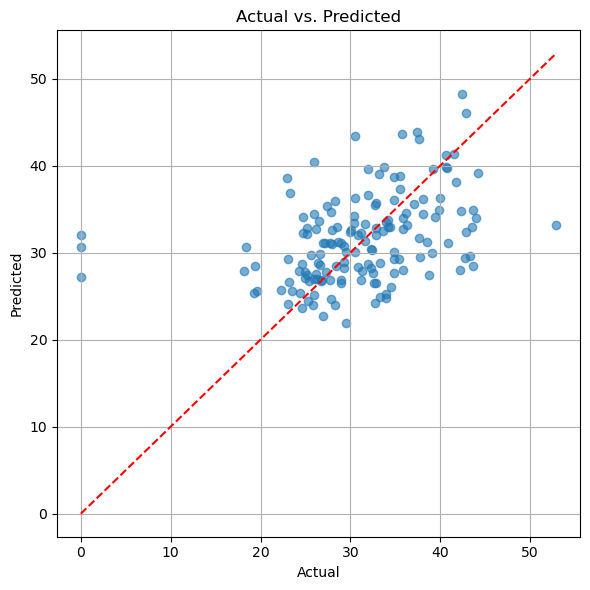

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(actuals, preds, alpha=0.6)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # 대각선 기준선
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()